In [ ]:
import gymnasium as gym  # Librería para ambientes de aprendizaje por refuerzo
import numpy as np  # Librería para cálculos matemáticos y arrays
import matplotlib.pyplot as plt  # Librería para crear gráficas
import pickle  # Librería para guardar/cargar objetos Python en archivos

In [ ]:
#Funcion para Ejecutar tanto el entrenamiento como la grafica de Python
def ejecutar(entrenando=True, renderizar=False):

    # CREAR EL AMBIENTE 
    env = gym.make('Pendulum-v1', render_mode='human' if renderizar else None)
    # Crea el ambiente del péndulo
    # Si renderizar=True, muestra ventana con animación
    # Si renderizar=False, solo hace los cálculos sin mostrar nada

    # HIPERPARÁMETROS
    
    
    tasa_aprendizaje = 0.1  # α (alpha) - Qué tan rápido aprende de nuevas experiencias
                            # 0.1 = aprende 10% de la nueva info, mantiene 90% de lo viejo
                            
    factor_descuento = 0.9  # γ (gamma) - Cuánto valora las recompensas futuras
                            # 0.9 = las recompensas futuras valen 90% de las actuales
                            
    epsilon = 1  # Probabilidad de explorar (elegir acción aleatoria)
                 # 1 = 100% aleatorio al inicio (pura exploración)
                 
    tasa_decaimiento_epsilon = 0.0002  # Cuánto reduce epsilon cada episodio
                                       # Poco a poco explora menos y explota más
                                       
    epsilon_minimo = 0.05  # Epsilon nunca baja de aquí
                          # Siempre mantiene 5% de exploración aleatoria
                          
    divisiones = 15  # Cuántos "pedazos" dividir el espacio continuo
                     # Más divisiones = más precisión pero más memoria

    # ============ DISCRETIZAR ESPACIO DE OBSERVACIÓN ============
    # El péndulo tiene estados continuos (infinitos valores posibles)
    # Los convertimos a discretos (valores finitos) para usar tabla Q
    
    # np.linspace crea arrays con valores igualmente espaciados entre mínimo y máximo
    
    x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], divisiones)
    # x representa cos(θ), el coseno del ángulo del péndulo
    # Va de -1 a 1, dividido en 15 pedazos
    # Ejemplo: [-1.0, -0.857, -0.714, ..., 0.714, 0.857, 1.0]
    
    y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], divisiones)
    # y representa sin(θ), el seno del ángulo del péndulo
    # Va de -1 a 1, dividido en 15 pedazos
    
    w = np.linspace(env.observation_space.low[2], env.observation_space.high[2], divisiones)
    # w representa la velocidad angular (qué tan rápido gira)
    # Va de -8 a 8, dividido en 15 pedazos

    # ============ DISCRETIZAR ESPACIO DE ACCIONES ============
    acciones = np.linspace(env.action_space.low[0], env.action_space.high[0], divisiones)
    # Las acciones son el torque (fuerza) aplicado al péndulo
    # Va de -2 a 2, dividido en 15 pedazos
    # Ejemplo: [-2.0, -1.71, -1.43, ..., 1.43, 1.71, 2.0]

    # ============ INICIALIZAR O CARGAR TABLA Q ============
    if(entrenando):
        # Si estamos entrenando, crear tabla Q nueva con todos valores en 0
        q = np.zeros((len(x)+1, len(y)+1, len(w)+1, len(acciones)+1))
        # Tabla 4D: [índice_x][índice_y][índice_w][índice_acción]
        # Tamaño: 16×16×16×16 = 65,536 valores
        # Cada valor Q representa: "qué tan bueno es tomar esta acción en este estado"
        # El +1 es porque np.digitize puede devolver índices de 0 hasta len(array)
    else:
        # Si no estamos entrenando, cargar tabla Q previamente entrenada
        f = open('pendulum.pkl', 'rb')  # Abrir archivo en modo lectura binaria
        q = pickle.load(f)  # Cargar la tabla Q guardada
        f.close()  # Cerrar archivo

    # ============ VARIABLES DE SEGUIMIENTO ============
    mejor_recompensa = -99999  # Guarda la mejor recompensa encontrada
                               # Empieza muy negativa para que cualquier cosa sea mejor
                               
    recompensas_por_episodio = []  # Lista que guarda la recompensa de cada episodio
                                   # Para después graficar el progreso
                                   
    episodio = 0  # Contador de episodios (intentos completos)

    # ============ BUCLE PRINCIPAL DE ENTRENAMIENTO ============
    while(True):  # Bucle infinito - hay que detenerlo manualmente con Ctrl+C

        # -------- RESETEAR AMBIENTE --------
        estado = env.reset()[0]  # Reinicia el péndulo a posición aleatoria
                                 # env.reset() devuelve (estado, info), tomamos solo estado
                                 # estado es un array: [cos(θ), sin(θ), velocidad_angular]
        
        # -------- DISCRETIZAR ESTADO INICIAL --------
        # np.digitize convierte valores continuos en índices discretos
        # Es como decir "¿en qué cajón del estante va este valor?"
        
        indice_x_actual = np.digitize(estado[0], x)
        # Si estado[0] = 0.5, busca en qué "cajón" de x cae
        # Devuelve un número de 0 a 16
        
        indice_y_actual = np.digitize(estado[1], y)
        # Discretiza el seno del ángulo
        
        indice_w_actual = np.digitize(estado[2], w)
        # Discretiza la velocidad angular

        # -------- VARIABLES POR EPISODIO --------
        recompensas = 0  # Acumulador de recompensas en este episodio
        pasos = 0  # Contador de pasos en este episodio

        # ============ BUCLE DEL EPISODIO ============
        # Un episodio = una sesión completa del péndulo hasta 200 pasos
        while(pasos < 200 or entrenando==False):
            # Si entrenando=True: ejecuta exactamente 200 pasos
            # Si entrenando=False: ejecuta infinitos pasos (para ver el resultado)

            # -------- SELECCIÓN DE ACCIÓN (POLÍTICA ε-GREEDY) --------
            if entrenando and np.random.rand() < epsilon:
                # EXPLORACIÓN: con probabilidad epsilon, elegir acción aleatoria
                # np.random.rand() genera número aleatorio entre 0 y 1
                # Si es menor que epsilon, explora
                
                accion = env.action_space.sample()  # Acción aleatoria del ambiente
                indice_accion = np.digitize(accion, acciones)  # Convertir a índice discreto
            else:
                # EXPLOTACIÓN: elegir la mejor acción según tabla Q
                # np.argmax encuentra el índice con el valor más alto
                
                indice_accion = np.argmax(q[indice_x_actual, indice_y_actual, indice_w_actual, :])
                # Busca en la tabla Q todas las acciones posibles para este estado
                # Los : significan "todas las acciones"
                # Devuelve el índice de la acción con mayor valor Q
                
                accion = acciones[indice_accion-1]  # Convertir índice a valor continuo
                # El -1 es porque los índices empiezan en 1 pero los arrays en 0

            # -------- EJECUTAR ACCIÓN EN EL AMBIENTE --------
            nuevo_estado, recompensa, _, _, _ = env.step([accion])
            # env.step() ejecuta la acción y devuelve:
            # - nuevo_estado: el estado después de aplicar la acción
            # - recompensa: qué tan bien fue (número negativo, 0 es perfecto)
            # - terminated: si terminó el episodio (no se usa en Pendulum)
            # - truncated: si se alcanzó límite de pasos (no se usa)
            # - info: información extra (no se usa)
            # [accion] porque step() espera array, no número suelto

            # -------- DISCRETIZAR NUEVO ESTADO --------
            indice_x_nuevo = np.digitize(nuevo_estado[0], x)
            indice_y_nuevo = np.digitize(nuevo_estado[1], y)
            indice_w_nuevo = np.digitize(nuevo_estado[2], w)
            # Convertimos el nuevo estado continuo a índices discretos

            # -------- ACTUALIZAR TABLA Q (ECUACIÓN DE Q-LEARNING) --------
            if entrenando:
                # Fórmula: Q(s,a) = Q(s,a) + α[r + γ*max(Q(s',a')) - Q(s,a)]
                # Donde:
                # s = estado actual, a = acción tomada
                # s' = nuevo estado, a' = todas las acciones posibles desde s'
                # r = recompensa recibida
                # α = tasa de aprendizaje, γ = factor de descuento
                
                q[indice_x_actual, indice_y_actual, indice_w_actual, indice_accion] = \
                    q[indice_x_actual, indice_y_actual, indice_w_actual, indice_accion] + \
                    tasa_aprendizaje * (
                        recompensa + factor_descuento * np.max(q[indice_x_nuevo, indice_y_nuevo, indice_w_nuevo, :])
                            - q[indice_x_actual, indice_y_actual, indice_w_actual, indice_accion]
                    )
                # Desglose:
                # 1. Tomamos el valor Q actual: q[estado_actual][accion]
                # 2. Le sumamos: α * (objetivo - valor_actual)
                # 3. El objetivo es: recompensa_inmediata + γ * mejor_valor_futuro
                # 4. Esto hace que Q converja al valor real esperado

            # -------- ACTUALIZAR ESTADO ACTUAL --------
            estado = nuevo_estado  # El nuevo estado ahora es el actual
            indice_x_actual = indice_x_nuevo
            indice_y_actual = indice_y_nuevo
            indice_w_actual = indice_w_nuevo
            # Movemos el "cursor" al nuevo estado para el siguiente paso

            # -------- ACUMULAR RECOMPENSA Y PASOS --------
            recompensas += recompensa  # Sumar recompensa al total del episodio
            pasos += 1  # Incrementar contador de pasos

            # -------- GUARDAR SI ES LA MEJOR RECOMPENSA --------
            if recompensas > mejor_recompensa:
                mejor_recompensa = recompensas  # Actualizar récord

                # Guardar tabla Q en archivo cuando hay nueva mejor recompensa
                if entrenando:
                    f = open('pendulum.pkl','wb')  # Abrir archivo en modo escritura binaria
                    pickle.dump(q, f)  # Guardar tabla Q completa
                    f.close()  # Cerrar archivo
                    # Esto permite continuar el entrenamiento después

        # ============ FIN DEL EPISODIO ============
        
        # -------- ALMACENAR RECOMPENSA DEL EPISODIO --------
        recompensas_por_episodio.append(recompensas)
        # Añadir la recompensa total de este episodio a la lista

        # -------- IMPRIMIR ESTADÍSTICAS CADA 100 EPISODIOS --------
        if entrenando and episodio != 0 and episodio % 100 == 0:
            # Solo si: estamos entrenando, no es episodio 0, y es múltiplo de 100
            
            # Calcular recompensa promedio de los últimos 100 episodios
            recompensa_promedio = np.mean(recompensas_por_episodio[len(recompensas_por_episodio)-100:])
            # len(...)-100: toma los últimos 100 elementos de la lista
            # np.mean: calcula el promedio
            
            print(f'Episodio: {episodio}, Epsilon: {epsilon:0.2f}, Mejor Recompensa: {mejor_recompensa}, Recompensa Promedio: {recompensa_promedio:0.1f}')
            # Imprime progreso: episodio actual, nivel de exploración, mejor récord, promedio reciente

            # -------- CREAR GRÁFICA DE PROGRESO --------
            recompensas_promedio = []  # Lista para guardar promedios móviles
            for t in range(episodio):
                # Para cada episodio desde 0 hasta el actual
                recompensas_promedio.append(np.mean(recompensas_por_episodio[max(0, t-100):(t+1)]))
                # Calcula promedio de 100 episodios centrado en t
                # max(0, t-100) evita índices negativos al inicio
                
            plt.clf()  # Limpiar el gráfico anterior (si existe)
            plt.plot(recompensas_promedio)  # Crear línea con los promedios
            plt.title('Progreso del Entrenamiento - Pendulum')  # Título
            plt.xlabel('Episodio')  # Etiqueta eje X
            plt.ylabel('Recompensa Promedio (últimos 100 episodios)')  # Etiqueta eje Y
            plt.savefig(f'pendulum.png')  # Guardar imagen
            # Esto crea tu gráfica "montaña" 🏔️

        elif not entrenando:
            # Si no estamos entrenando, solo mostrar resultado de cada episodio
            print(f'Episodio: {episodio} Recompensa: {recompensas:0.1f}')

        # -------- REDUCIR EPSILON (MENOS EXPLORACIÓN) --------
        epsilon = max(epsilon - tasa_decaimiento_epsilon, epsilon_minimo)
        # Resta tasa_decaimiento_epsilon a epsilon
        # max(..., epsilon_minimo) asegura que nunca baje de 0.05
        # Con el tiempo, explora menos y explota más lo aprendido

        episodio += 1  # Incrementar contador de episodios

        # NOTA: ESTE BUCLE WHILE NUNCA TERMINA
        # Hay que detener el entrenamiento manualmente con Ctrl+C
        # cuando la gráfica muestre que ya aprendió bien

C:\Users\user1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gymnasium\utils\passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
C:\Users\user1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gymnasium\utils\passive_env_checker.py:245: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'numpy.ndarray'>
  logger.warn(


Episodio: 100, Epsilon: 0.98, Mejor Recompensa: [-1523.1786], Recompensa Promedio: -1208.2
Episodio: 200, Epsilon: 0.96, Mejor Recompensa: -0.014573396270744861, Recompensa Promedio: -1209.0
Episodio: 300, Epsilon: 0.94, Mejor Recompensa: -0.014573396270744861, Recompensa Promedio: -1259.0
Episodio: 400, Epsilon: 0.92, Mejor Recompensa: -0.014573396270744861, Recompensa Promedio: -1257.2
Episodio: 500, Epsilon: 0.90, Mejor Recompensa: [-1153.1863], Recompensa Promedio: -1240.2
Episodio: 600, Epsilon: 0.88, Mejor Recompensa: [-1201.2506], Recompensa Promedio: -1194.6
Episodio: 700, Epsilon: 0.86, Mejor Recompensa: [-1063.837], Recompensa Promedio: -1255.5
Episodio: 800, Epsilon: 0.84, Mejor Recompensa: -0.7388078798378634, Recompensa Promedio: -1231.9
Episodio: 900, Epsilon: 0.82, Mejor Recompensa: -5.083943028817123, Recompensa Promedio: -1228.5
Episodio: 1000, Epsilon: 0.80, Mejor Recompensa: [-1267.0203], Recompensa Promedio: -1260.6
Episodio: 1100, Epsilon: 0.78, Mejor Recompensa: [

C:\Users\user1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


TypeError: unsupported format string passed to numpy.ndarray.__format__

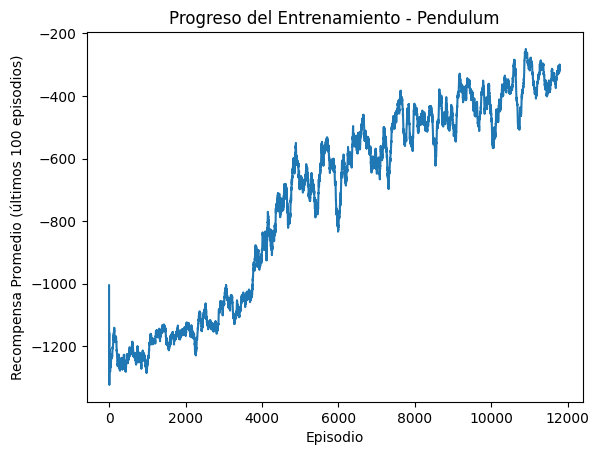

In [13]:
# ESTE BUCLE WHILE NUNCA TERMINA. DETENER EL ENTRENAMIENTO MANUALMENTE CUANDO SE ENCUENTRE LA SOLUCIÓN.


if __name__ == '__main__':
    ejecutar(entrenando=True, renderizar=False)

In [ ]:
# ESTE BUCLE WHILE NUNCA TERMINA. DETENER EL ENTRENAMIENTO MANUALMENTE CUANDO SE ENCUENTRE LA SOLUCIÓN.

ejecutar(entrenando=False, renderizar=True)

KeyboardInterrupt: 

: 